# 📚 Libraries

In [1]:
import numpy as np
import pandas as pd
import psycopg as pg
from sqlalchemy import create_engine
import pickle
import re
import spacy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import zipcodes
import pprint

# Helper functions

## `info_df`

This is a function that I plan to keep developing with more information columns in the returned dataframe.

In [2]:
def info_df(df):
    non_null = len(df)-df.isnull().sum().values
    null = df.isnull().sum().values
    pct_non_null = np.round(100 * non_null / (non_null + null), 0)
    types = df.dtypes.values
    
    info_df = pd.DataFrame({
            "name": df.columns,
            "non_null": non_null,
            "null": null,
            "non_null_pct": pct_non_null,
            "type": types
        }).set_index('name')
        
    return info_df

# 🛡️ NIBRS data

Data on incidents and offenses.

Local PostgreSQL database created from downloaded `.csv` files.

Using SQLAlchemy only b/c Pandas complains when you don't.

## Connection settings & engine

In [3]:
# Database connection settings
DB_NAME = "NIBRS"
DB_USER = "postgres"
DB_PASSWORD = "admin"
DB_HOST = "localhost"
DB_PORT = "5432"

# SQLAlchemy connection string
connection_string = f"postgresql+psycopg://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

## Data

In [6]:
# Pandas kept complaining about this so I had to install SQLAlchemy and do it that way
# with pg.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASSWORD, host=DB_HOST, port=DB_PORT) as conn:
#     nibrs_incidents = pd.read_sql(nibrs_incidents_sql, conn)

In [4]:
# incidents reported by either EBRPD (police department) or EBRPSO (sheriff's office)
nibrs_incidents_sql = 'SELECT agency_id, incident_id, incident_date, incident_hour FROM NIBRS_INCIDENT WHERE agency_id IN (7202, 7204)'
nibrs_offenses_sql = 'SELECT offense_id, incident_id, offense_code, attempt_complete_flag FROM NIBRS_OFFENSE'
nibrs_code_sql = 'SELECT offense_code as code, offense_name as description, crime_against, offense_category_name as category, offense_group as group FROM nibrs_offense_type'

nibrs_codes = pd.read_sql(nibrs_code_sql, engine)
nibrs_codes.columns = ['nibrs_' + c for c in nibrs_codes.columns]

nibrs_offenses = pd.read_sql(nibrs_offenses_sql, engine)
nibrs_incidents = pd.read_sql(nibrs_incidents_sql, engine)
nibrs_crimes = pd.merge(left=nibrs_incidents, right=nibrs_offenses, on='incident_id')
nibrs_crimes.columns = ['nibrs_' + c for c in nibrs_crimes.columns]

In [220]:
nibrs_crimes.sample(4)

,nibrs_agency_id,nibrs_incident_id,nibrs_incident_date,nibrs_incident_hour,nibrs_offense_id,nibrs_offense_code,nibrs_attempt_complete_flag
18917,7204,150967597,2021-07-07,16,180930640,13B,C
7369,7202,150917086,2021-09-17,9,180872288,220,A
17591,7204,150966620,2021-06-17,1,180929521,23A,C
23648,7204,150971782,2021-09-17,7,180935280,13B,C


# 👮🏼‍♀️ EBRP Data

Combined Crime Incidents from Open Data BR.

"Combined": from Baton Rouge Police Department and East Baton Rouge Parish Sheriff's Office

## Initial file load

### Loading parameters

In [5]:
filename = 'EBRP_Combined_Crime_Incidents_20241106.csv'

api_names = ['agency_name', 'incident_number', 'charge_id', 'supplemental', 'charge_date', 'report_date', 'approved_date', 'attempted_committed', 'street', 'street_2', 'city', 'state', 'postal_code', 'district', 'zone', 'sub_zone', 'statute_title', 'statute_description', 'statute_category', 'crime_against', 'nibrs_code', 'offense_description', 'census_block_group', 'council_district', 'crime_prevention_district', 'neighborhood', 'longitude', 'latitude', 'enforcement_agency_id', 'geolocation']

# Datetime columns
dt_cols = ['charge_date', 'report_date', 'approved_date']

# Columns that will have category data type
cat_cols = ['agency_name', 'attempted_committed', 'city', 'state', 'postal_code', 'district', 'zone', 'sub_zone', 'statute_title', 'statute_category', 'crime_against', 'nibrs_code', 'offense_description', 'council_district', 'crime_prevention_district', 'neighborhood', ]

# Column types that will have String data type
str_cols = ['incident_number', 'charge_id', 'street', 'street_2', 'statute_description']

# Create {column_name:dtype} dictonary to pass to dtype argument
str_types = {col_name:'string' for col_name in str_cols}
cat_types = {col_name:"category" for col_name in cat_cols}
dtypes = {**cat_types, **str_types}

# Do not load these columns. They contribute no information.
omit_cols = ['census_block_group', 'geolocation', 'enforcement_agency_id' ]
keep_cols = [col_name for col_name in api_names if col_name not in omit_cols]

### Load from scratch (only when necessary)

In [ ]:
# 🛑✋🏼 Do not run this code unless the loading parameters have changed.
# Load the pickle, below, instead.


# crimes = pd.read_csv(filename,
#                            header=0,
#                            names=api_names,
#                            parse_dates=dt_cols,
#                            usecols=keep_cols,
#                            dtype=dtypes)

Save pickle

In [ ]:
# with open('initial_load.pickle', 'wb') as handle:
#     pickle.dump(crimes, handle)

### 🥒 Load pickle

In [30]:
with open('brpdso_charges.pickle', 'rb') as handle:
    crimes = pickle.load(handle)

## Most basic cleaning

### 🚩 Basic cleaning

In [31]:
# Remove crimes committed before 2021
crimes = crimes[crimes.charge_date.dt.year >= 2021]

# Remove November 2024 data
crimes = crimes[crimes.charge_date <= '2024-10-31']

# Remove duplicates
num_rows_before = crimes.shape[0]
# crimes = crimes.drop_duplicates(inplace=True)
# Note to self: Start using assigment instead of inplace=True
# => Easier to search for lines that change the object.
crimes = crimes.drop_duplicates()
num_rows_after = crimes.shape[0]
print(f'{num_rows_before - num_rows_after:,} duplicate rows removed ({num_rows_before:,} to {num_rows_after:,})')

# Replace NIBRS code 0 with NaN
crimes['nibrs_code'] = crimes['nibrs_code'].astype('string').replace({'0':np.nan}).astype('category')

507 duplicate rows removed (277,494 to 276,987)


### 🚩 Unify string cases -- convert ALL CAPS to lowercase or Title Case

Also prevent looking at so many ALL CAPS

In [32]:
# lower case
lower_case = ['attempted_committed', 'crime_against', 'offense_description', 'statute_description', 'statute_title', 'statute_category' ]
for c in lower_case:
    col_dtype = dtypes[c]
    crimes[c] = crimes[c].str.lower().astype(col_dtype) # Have to reapply the category type after performing string operation

# Title Case
title = ['street',	'street_2',	'city', 'crime_prevention_district', 'neighborhood']
for c in title:
    col_dtype = dtypes[c]
    crimes[c] = crimes[c].apply(lambda str: str.title() if not pd.isna(str) else str).astype(col_dtype) # Have to reapply the category type after performing string operation


There is only one record missing statute information.  It contains both the sole na in statute_title and the sole na value in statute description.

In [10]:
crimes[crimes.statute_title.isna()]

,agency_name,incident_number,charge_id,supplemental,charge_date,report_date,approved_date,attempted_committed,street,street_2,...,statute_description,statute_category,crime_against,nibrs_code,offense_description,council_district,crime_prevention_district,neighborhood,longitude,latitude
57816,BRPD,24-200057,1203905,NaN,2024-05-01 05:31:00,2024-05-01 05:31:00,2024-07-14 13:58:38,NaN,Dougherty Dr & Blackwell Dr,<NA>,...,<NA>,other,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN


### 🚩 Remove row with no statute information

In [33]:
crimes = crimes[crimes.statute_title.notna()]

## Statute titles

Sometimes title is recorded with a colon separating the title number from the section number (14:1.3), other times with a dot separating the two (14.1.3).

Make sure separator is a colon, uniformly, (correct way to cite the statute).

### 🚩 Clean titles

In [34]:
def replace_first_punctuation(text):
    # Pattern to match sequences of digits followed by the first punctuation
    match = re.match(r"^(\d+)([^\w\s])", text)
    if match:
        # Only replace the first punctuation after the sequence of digits
        return re.sub(r"(?<=\d)([^\w\s])", ":", text, count=1)
    return text

crimes['statute_title'] = crimes['statute_title'].apply(replace_first_punctuation).astype('category')

### Other statute title investigation (Questions only-- no dataframe changes)

Count number of statute titles associated with each statute description

In [24]:
description_title_counts = crimes.groupby('statute_description')['statute_title'].nunique().rename('title_count')
desc_with_multiple_titles = description_title_counts[description_title_counts > 1].index.to_list()
print(f'Most number of titles per description: {description_title_counts.max()}')
print(f'Number of descriptions with more than one associated title: {len(desc_with_multiple_titles)}')

Most number of titles per description: 6
Number of descriptions with more than one associated title: 150


In [25]:
too_many_titles = crimes[crimes.statute_description.isin(desc_with_multiple_titles)][['statute_description', 'statute_title', 'statute_category']]
too_many_titles = too_many_titles.drop_duplicates().sort_values('statute_description')

too_many_titles.head()

,statute_description,statute_title,statute_category
63338,access device fraud/counterfeiting/forgery,14:70.4,theft
6699,access device fraud/counterfeiting/forgery,14:70.4/x,theft
6494,aggravated arson,14:51,property damage
6508,aggravated arson,14:51/h,criminal damage to property
676,aggravated assault,14:37,assault


In [26]:
desc_with_most_titles = description_title_counts[description_title_counts == description_title_counts.max()].index.to_list()
# desc_with_most_titles
crimes[crimes.statute_description.isin(desc_with_most_titles)][['statute_description', 'statute_title', 'statute_category']].drop_duplicates().sort_values(['statute_description', 'statute_title'])

,statute_description,statute_title,statute_category
166,theft,13:67,theft
101,theft,14:67,theft
2010,theft,14:67/b,theft
16531,theft,14:67/e,theft
744,theft,14:67/s,theft
1538,theft,14:67/z,theft


🧠 It looks like titles can also include 'subparts'.  e.g., '14:67/B' refers to title 14, part 67, subpart B.

## Statute categories

### Clean category data

🚩 Count number of statute categories associated with each statute description


In [35]:
description_category_counts = crimes.groupby('statute_description')['statute_category'].nunique().rename('category_count')
descriptions_with_multiple_categories = description_category_counts[description_category_counts > 1].index.to_list()

print(f'Max # categories: {description_category_counts.max()}')
print(f'{len(descriptions_with_multiple_categories)} descriptions have more than 1 category')

Max # categories: 2
48 descriptions have more than 1 category


🚩 Because there are no more than 2 categories per description we can spread them across columns.

In [36]:
# Select statute description and categories just for the descriptions that have two categories
multiples = crimes[crimes.statute_description.isin(descriptions_with_multiple_categories)][['statute_description', 'statute_category']]
multiples = multiples.drop_duplicates().sort_values('statute_description')

# For each description, number the categories associated with it.
multiples['cat_instance_num'] = multiples.groupby('statute_description')['statute_category'].cumcount()

# Reshape so that the categories are spread across two columns
doubles = multiples.pivot(index='statute_description', columns='cat_instance_num', values='statute_category').sort_index()

In [17]:
doubles.sample(12)

cat_instance_num,0,1
statute_description,,
simple obstruction of a highway of commerce,nuisance,traffic
aggravated arson,criminal damage to property,property damage
vehicular negligent injuring,traffic,battery
criminal mischief - throwing rocks / dangerous objects,criminal damage to property,nuisance
failure to yield after stop,traffic,other
illegal use of weapons or dangerous instrumentalities,firearm,battery
simple battery,other,battery
false imprisonment,other,assault
headlights required,other,traffic


It looks like a lot of these pairs have one category "Other" -- that can be replaced with the other, more definitive category.

In [37]:
# Split into two sets -- one where one of the categories is "Other" & one where there are truly two different categories
others = doubles[(doubles == 'other').any(axis=1)].copy()
true_doubles = doubles[(doubles != 'other').all(axis=1)].copy()

print(f'{doubles.shape[0]} doubles')
print('-' * 10)
print(f'{others.shape[0]} have one category as "other"')
print(f'{true_doubles.shape[0]} are true doubles')

48 doubles
----------
37 have one category as "other"
11 are true doubles


### 🚩 "Other" replacement dictionary

In [38]:
# replace 'OTHER' with empty string... the Categorical way
others = others.astype('string').replace('other', '') 
others['actual_category'] = others[0] + others[1]

other_replacements = others['actual_category'].to_dict()

### Pairs with truly ambiguous category associations replacement dictionary

Replacement dictionary: Replace the lesser used category with the more common category.

In [565]:
ambiguous_descriptions = true_doubles.index.to_list()
ambig = crimes[crimes['statute_description'].isin(ambiguous_descriptions)]

ambiguous_replacements = ambig.groupby('statute_description')['statute_category'].agg(lambda category: category.value_counts().index[0]).to_dict()

### 🚩 Update categories

For now, **do not** substitute ambiguous categories.  Ignore the replacement dictionary created for that.

In [39]:
# Not remapping ambiguous categories at this time
# replacement_dict = {**other_replacements, **ambiguous_replacements}
replacement_dict = other_replacements

def update_statute_category(row):
    stat_desc = row['statute_description'] # key
    stat_cat = row['statute_category'] # replacement_value
    # if pd.isna(stat_desc):
    #     return np.nan
    if stat_desc in replacement_dict.keys():
        return replacement_dict[stat_desc]
    # elif stat_desc == 'OTHER':
    #     return np.nan
    else:
        return stat_cat


crimes['statute_category'] = crimes.apply(update_statute_category, axis='columns').astype('category')

There are still a lot of crimes categorized as "Other"

In [ ]:
n_other = crimes[crimes.statute_category == "other"].shape[0]
print(f"{n_other} crimes have category 'other' ({n_other/crimes.shape[0]:.2%})")

83618 crimes have category 'Other' (30.19%)


## Information hierarchy

In [570]:
n_desc = crimes.statute_description[crimes.statute_description.notna()].nunique()
n_cat = crimes.statute_category[crimes.statute_category.notna()].nunique()
n_title = crimes.statute_title[crimes.statute_title.notna()].nunique()

counts = pd.Series({'n_desc':n_desc, 'n_cat':n_cat, 'n_title':n_title}).sort_values()
counts

n_cat        19
n_title    1013
n_desc     1155
dtype: int64

In [ ]:
n_not_used = crimes[crimes.statute_category == 'not used'].shape[0]
print(f'{n_not_used} crimes have category "not used" ({n_not_used/crimes.shape[0]:.2%})')

145 crimes have category "Not Used" (0.05%)


### Most prevalent categories

In [41]:
cat_counts = crimes[~crimes.statute_category.isin(['other', 'not used'])].groupby('statute_category', observed=True)['charge_id'].count().sort_values(ascending=False).rename('n_charges').reset_index()
cat_counts

,statute_category,n_charges
0,theft,58642
1,battery,24003
2,non-residential burglary,21377
3,criminal damage to property,18964
4,traffic,15330
5,narcotics,13949
6,nuisance,10019
7,assault,7604
8,firearm,7082
9,residential burglary,4412


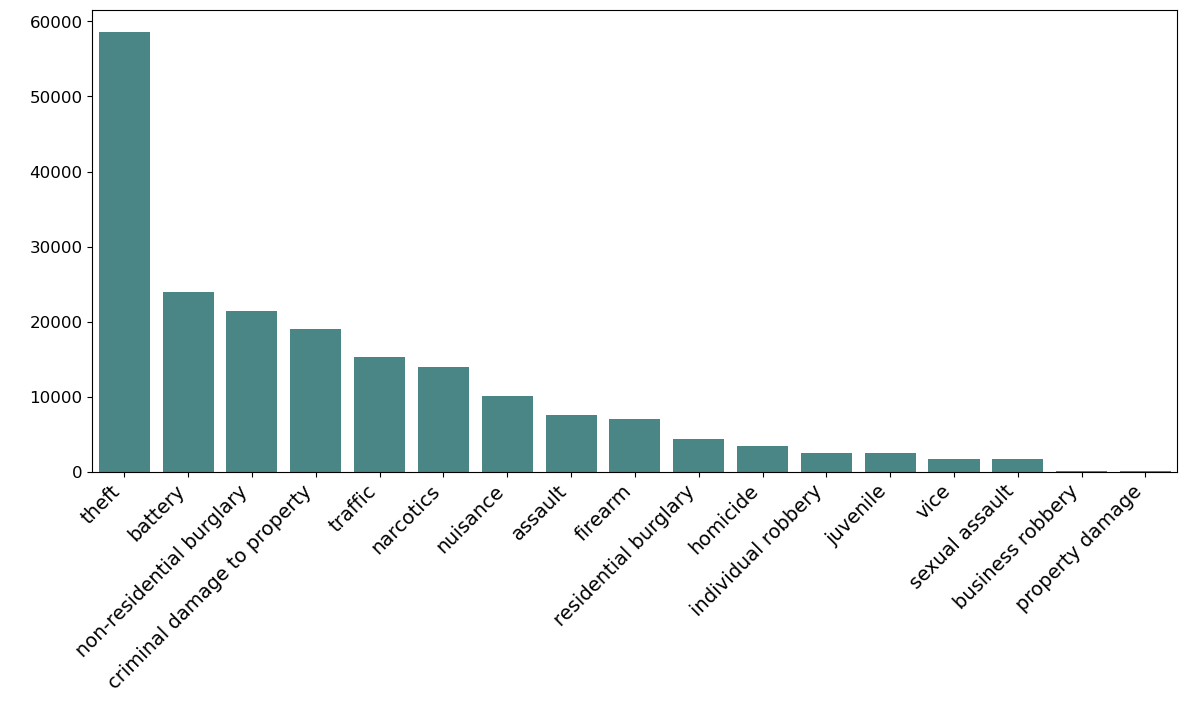

In [42]:
plt.figure(figsize=(14, 6))
bar_color = sns.color_palette("crest")[2]
sns.barplot(
    data=cat_counts,
    x='statute_category',
    y ='n_charges',
    order=cat_counts['statute_category'],
    color=bar_color
)

plt.xlabel(" ")
plt.ylabel(" ")
# plt.title('Charges by statute category', y=0.9, x=0.8, fontsize = 20)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()

In [43]:
# Last 3 months
l3 = crimes[crimes.charge_date.between('2024-08-01', '2024-10-31')]
cats = crimes[~crimes.statute_category.isin(['other', 'not used'])]
l3_cats = l3[l3.index.isin(cats.index)]
l3_cat_counts = l3_cats.groupby('statute_category', observed=True)['charge_id'].count().sort_values(ascending=False)
l3_cat_counts

statute_category
theft                          1838
traffic                         905
battery                         678
non-residential burglary        508
narcotics                       471
criminal damage to property     430
nuisance                        373
assault                         208
firearm                         182
vice                             87
residential burglary             79
juvenile                         68
individual robbery               55
sexual assault                   31
homicide                         18
property damage                   4
business robbery                  2
Name: charge_id, dtype: int64

### Statute categories over time

In [183]:
crimes['month_year'] = crimes['charge_date'].dt.to_period('M').dt.start_time

def category_time_summary(category):

    if not category in list(crimes.statute_category.unique()):
        return 'Invalid statute category'
    
    # rc stands for runtime configuration -- dictionary where you can pass specific
    # parameters to override the default settings of a chosen style
    sns.set_style(style="whitegrid", rc={'grid.color':'.95', 'axes.edgecolor': '.95'})

    # count # of charges in that category for each month
    df = crimes[crimes.statute_category == category].groupby('month_year')['charge_id'].count()
    df = df.reset_index().rename(columns={'charge_id':'charges'})
    df['month'] = df['month_year'].dt.month
    df['year'] = df['month_year'].dt.year
    df = df[['year', 'month', 'charges']]

    # Plot each year's time series in its own facet
    # relplot stands for 'relational plot'
    # Use additional argument 'row' to specify an additional feature
    # for rows (remove col_wrap argument)
    g = sns.relplot(
        data=df,
        x="month", y="charges", col="year", hue="year",
        kind="line", palette="crest", linewidth=3, zorder=5,
        col_wrap=2, height=3, aspect=1.5, legend=False,
    )

    # Iterate over each subplot to customize further
    for year, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.85, .9, year, transform=ax.transAxes, fontweight="bold")

        # Plot every year's time series in the background
        sns.lineplot(
            data=df, x="month", y="charges", units="year",
            estimator=None, color=".7", linewidth=1, ax=ax,
        )

    # Force a tick for every month
    ax.set_xticks(range(1,13))

    # Tweak the supporting aspects of the plot
    g.set_titles("")
    g.set_axis_labels("", "Charges")
    g.tight_layout()

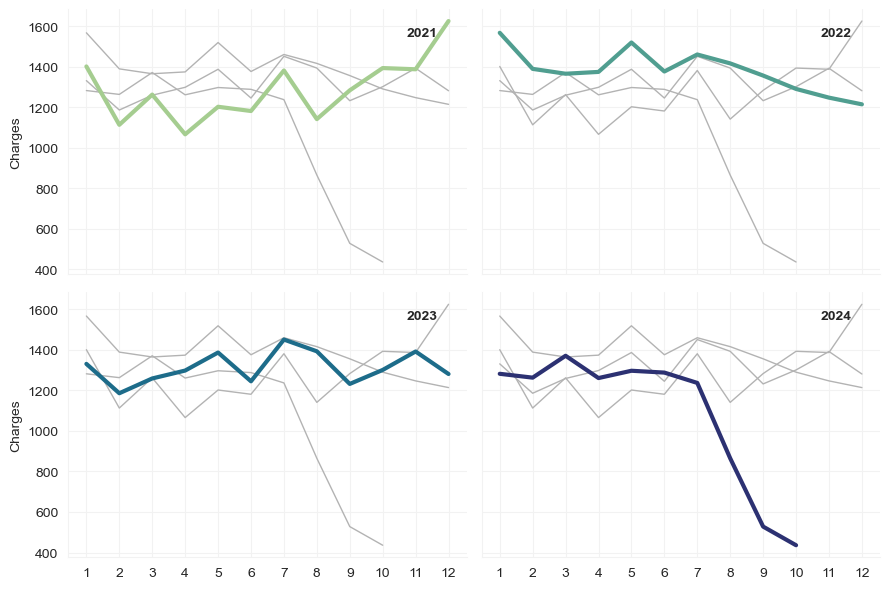

In [184]:
category_time_summary('theft')

## Maps

### Plottable crimes

Do not  plot crimes with zip code missing (nan) or outside of East Baton Rouge Parish

In [44]:
bad_zip_codes = []
for zip_code in crimes.postal_code.unique():
    try:
        info = zipcodes.matching(str(zip_code))[0]
        if info['county'] != 'East Baton Rouge Parish':
            bad_zip_codes.append(zip_code)
    except:
        bad_zip_codes.append(zip_code)

In [45]:
baton_rouge = ~crimes.postal_code.isin(bad_zip_codes)
valid_coordinates = crimes.latitude.notna() & crimes.longitude.notna()
in_date_range = crimes.charge_date.between('2024-08-01', '2024-10-31')

plottable_crimes = crimes[(baton_rouge) & (valid_coordinates) & (in_date_range)]

<!-- ### The map -->

### The map

In [46]:
def show_map(category):
    if category not in list(crimes.statute_category.unique()):
        return "Invalid category"
    category_crimes = plottable_crimes[plottable_crimes.statute_category == category]
    map = category_crimes.hvplot.points(
        'longitude',
        'latitude',
        geo=True,
        alpha=0.7,
        tiles='CartoLight',
        frame_width = 600,
        frame_height = 700,
        color='#254b7f'
    )
    # map.save(category+'_map.png')

    return map

In [47]:
category = 'theft'
map = show_map(category)
map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]

### A map of drunkenness

In [49]:
plottable_crimes = crimes[(baton_rouge) & (valid_coordinates)] # Remove the date range

drunk_in_statute = plottable_crimes.statute_description.astype('string').fillna('').str.contains('drunk')
drunk_in_offense = plottable_crimes.offense_description.astype('string').fillna('').str.contains('drunk')
drunk = plottable_crimes[(drunk_in_statute) | (drunk_in_offense)]

drunk.hvplot.points('longitude', 'latitude', geo=True, alpha=0.7, tiles='CartoLight', frame_width = 600, frame_height = 700, color='#E97132')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]

## Why are there so many missing `nibrs_code`s?

In [222]:
print(info_df(crimes).loc['nibrs_code', :])

non_null                187227
null                     89759
non_null_pct              68.0
type            string[python]
Name: nibrs_code, dtype: object


## Predicting missing NIBRS data

NIBRS code facilitates data comparison with other localities (other states; USA overall).

30% of data is missing NIBRS code.  Can existing data (BR data) be used to make a good guess at what the code should be?

BR crime information data: statute category, statute description, statute title, and offense description.

- Easy target: NIBRS group (A or B, see below)
- Hard target: NIBRS code (85 different codes)


NIBRS groups crimes into 'A' and 'B' groups. 'A' crimes are serious (theft, assault, narcotics) while Group B crimes are generally less so (disorderly conduct).

If we can confidently predict the group of a crime without knowing its NIBRS code, we can use the predictions to characterize the offenses that do not have an NIBRS code.

In [242]:
sample = crimes.sample(1).squeeze()
sample

agency_name                                                  BRPD
incident_number                                         24-013858
charge_id                    DAF7E01C-0B08-476A-BC5E-1ACD90500641
supplemental                                                  0.0
charge_date                                   2024-02-11 02:24:24
report_date                                   2024-02-12 12:57:17
approved_date                                 2024-02-19 03:20:38
attempted_committed                                     committed
street                                5000 S Sherwood Forest Blvd
street_2                                                     <NA>
city                                                  Baton Rouge
state                                                          LA
postal_code                                                 70816
district                                                        3
zone                                                           3F
sub_zone  

In [244]:
sample.to_csv('single_sample.csv')

### 🚩 Merge in NIBRS code information

In [50]:
nibrs_code_groups = nibrs_codes[['nibrs_code', 'nibrs_group']]

if not 'nibrs_group' in crimes.columns:
    crimes = pd.merge(left=crimes, right=nibrs_code_groups, on='nibrs_code', how='left')

# For some reason all the codes have a bunch of extra spaces in them
crimes['nibrs_group'] = crimes['nibrs_group'].str.replace(r'\s+', '', regex=True)
crimes['nibrs_group'] = crimes['nibrs_group'].fillna('')

has_codes = crimes[(crimes.nibrs_code.notna()) & (crimes.nibrs_code != '90I')] # Exclude runaways

### Group balance

In [51]:
n = has_codes.shape[0]
nA = has_codes[has_codes.nibrs_group=='A'].shape[0]
nB = has_codes[has_codes.nibrs_group=='B'].shape[0]
pA = nA / n
pB = nB / n
print(f'A: {pA:.2%}')
print(f'B: {pB:.2%}')

A: 89.14%
B: 10.86%


### Tokenize feature columns

#### 🚩 Prep: Replace NaN with empty strings

In [52]:
feature_columns = ['statute_description', 'offense_description', 'statute_title', 'statute_category']

for c in feature_columns:
    is_category = crimes[c].dtype == 'category'
    crimes[c] = crimes[c].astype('string').fillna('')
    if is_category:
        crimes[c] = crimes[c].astype('category')

#### Tokenizer function

In [53]:
nlp = spacy.load('en_core_web_sm')

def get_tokens(text):
    all_tokens = nlp(text)
    keep_tokens = []
    entity_list = [entity_span.text for entity_span in all_tokens.ents] #there shouldn't be any but just in case
    for t in all_tokens:
        # still works OK on statute titles
        if not t.is_stop or t.is_punct or t.is_digit:
            if t.text in entity_list:
                keep_tokens.append(t.text)
            else:
                keep_tokens.append(t.lemma_.lower())

    return ' '.join(keep_tokens)

#### Generate the tokens.  ⚠️ Takes ~40 min to run

Save a pickle for future loads

In [ ]:
# tokenized_columns = pd.DataFrame()
# for c in feature_columns:
#     tokenized_columns[c] = crimes[c].astype('string').apply(get_tokens).astype('string)

# with open('tokenized_text_columns.pickle', 'wb') as handle:
#     pickle.dump(tokenized_columns, handle)

Load the pickle instead when possible

In [54]:
with open('tokenized_text_columns.pickle', 'rb') as handle:
    tokenized_columns = pickle.load(handle)

👇🏽 Can remove this cell after the next token run

In [55]:
for c in tokenized_columns.columns:
    tokenized_columns[c] = tokenized_columns[c].astype('string')

### Things that don't change

In [56]:
big_X = tokenized_columns[tokenized_columns.index.isin(has_codes.index)] # only rows that have NIBRS codes
y = has_codes[['nibrs_code', 'nibrs_group']]
kfold = KFold()

### 4 feature columns

In [57]:
X_tokens = big_X.agg(' '.join, axis=1)

# X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(X_tokens, y)

# cv = CountVectorizer()
# X_train = cv.fit_transform(X_train_tokens)
# X_test = cv.transform(X_test_tokens)

### Feature subsets

In [58]:
# Set up a dictionary to hold all the information
feature_sets = ({
    "all_columns": {
        'columns': ['statute_description', 'offense_description', 'statute_title', 'statute_category'],
        'classification_scores': pd.DataFrame(columns=['target', 'model', 'training_score', 'test_score'])
    },
    "words_only" : {
        'columns':['statute_description', 'offense_description', 'statute_category'],
        'classification_scores': pd.DataFrame(columns=['target', 'model', 'training_score', 'test_score'])
    },
    "title_only" : {
        'columns':['statute_title'],
        'classification_scores': pd.DataFrame(columns=['target', 'model', 'training_score', 'test_score'])
    }
})

### Easy target: `nibrs_group` (2 classifiers)

In [59]:
models = ({
    'Support Vector Classification':SVC(kernel='linear', probability=True),
    'Logistic Regression': LogisticRegression()
})

target = 'nibrs_group'

for feature_set_name, feature_set_info in feature_sets.items():
    # Select features
    columns = feature_set_info['columns']
    X_tokens = big_X[columns].agg(' '.join, axis=1)
    X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(X_tokens, y)

    # Transform to count matrix
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train_tokens)
    X_test = vectorizer.transform(X_test_tokens)

    for model_name, model in models.items():
        model.fit(X_train, y_train[target])
        
        train_results = cross_val_score(model, X_train, y_train[target], cv = kfold).mean()
        test_results = cross_val_score(model, X_test, y_test[target], cv=kfold).mean()
        
        score_df = feature_set_info['classification_scores']
        # score_df = pd.concat([score_df, [target, model_name, train_results, test_results]])
        score_df.loc[len(score_df)] = [target, model_name, train_results, test_results]
        
        print(f'\n{model_name}:')
        print(f'{train_results:.2%}')
        print(f'{test_results:.2%}')


Support Vector Classification:
100.00%
100.00%

Logistic Regression:
100.00%
99.98%

Support Vector Classification:
100.00%
99.99%

Logistic Regression:
99.99%
99.99%

Support Vector Classification:
98.61%
98.55%

Logistic Regression:
98.56%
98.55%


In [111]:
with open('festure_sets_after_easy_model.pickle', 'wb') as handle:
    pickle.dump(feature_sets, handle)

### Hard target (Random Forest)

In [113]:
target = 'nibrs_code'

for name, feature_set_info in feature_sets.items():
    columns = feature_set_info['columns']
    X_tokens = big_X[columns].agg(' '.join, axis=1)
    X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(X_tokens, y)

    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train_tokens)
    X_test = vectorizer.transform(X_test_tokens)

    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train[target])

    training_score = cross_val_score(rfc, X_train, y_train[target], cv = kfold).mean()
    test_score = cross_val_score(rfc, X_test, y_test[target], cv=kfold).mean()

    score_df = feature_set_info['classification_scores']
    score_df.loc[len(score_df)] = [target, 'Random Forest', training_score, test_score]

    train_pred = pd.DataFrame({'set':'train', 'actual':y_train[target] ,'predictions':rfc.predict(X_train)})
    test_pred = pd.DataFrame({'set':'test', 'actual':y_test[target] ,'predictions':rfc.predict(X_test)})
    feature_set_info['nibrs_code_predictions'] = pd.concat([train_pred, test_pred])

    print(f'\nFeature set: {name}')
    print(f'{training_score:.2%}')
    print(f'{test_score:.2%}')


Feature set: all_columns
99.98%
99.96%

Feature set: words_only
99.98%
99.98%

Feature set: title_only
77.85%
77.94%


In [246]:
pprint.pprint(feature_sets)

{'all_columns': {'classification_scores':         target                          model  training_score  test_score
0  nibrs_group  Support Vector Classification        0.999993    0.999936
1  nibrs_group            Logistic Regression        0.999922    0.999872
2   nibrs_code                  Random Forest        0.999793    0.999594,
                 'columns': ['statute_description',
                             'offense_description',
                             'statute_title',
                             'statute_category'],
                 'nibrs_code_predictions':           set actual predictions
159419  train    13B         13B
62297   train    290         290
26631   train    23F         23F
212068  train    290         290
53613   train    13B         13B
...       ...    ...         ...
120022   test    13A         13A
158990   test    11A         11A
170916   test    290         290
165147   test    220         220
210867   test    23F         23F

[187215 rows x 3 colu

In [248]:
feature_sets['all_columns']['classification_scores']

,target,model,training_score,test_score
0,nibrs_group,Support Vector Classification,0.999993,0.999936
1,nibrs_group,Logistic Regression,0.999922,0.999872
2,nibrs_code,Random Forest,0.999793,0.999594


In [ ]:
all_scores = pd.DataFrame(columns=['feature_set', 'target', 'model', 'training_score', 'test_score'])
for fs_name, fs_info in feature_sets.items():
    cs = fs_info['classification_scores']
    cs['feature_set'] = fs_name
    all_scores = pd.concat([all_scores, cs])

all_scores.to_csv('classification_scores.csv')


C:\Users\jlefe\AppData\Local\Temp\ipykernel_33300\2401865484.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_scores = pd.concat([all_scores, cs])


In [262]:
pred = feature_sets['words_only']['nibrs_code_predictions']

pred.sample(20).to_csv('predictions_sample.csv', index=False)

##### Title as just label-encoding

In [263]:
X = has_codes.statute_title.cat.codes.to_frame()
z = has_codes['nibrs_code']
X_train, X_test, z_train, z_test = train_test_split(X, y)

rfc2 = RandomForestClassifier()
rfc2.fit(X_train, z_train)

train_results = cross_val_score(rfc2, X_train, y_train['nibrs_code'], cv = kfold).mean()
test_results = cross_val_score(rfc2, X_test, y_test['nibrs_code'], cv=kfold).mean()
print('Random Forest:')
print(f'{train_results:.2%}')
print(f'{test_results:.2%}')

Random Forest:
10.30%
9.90%


No!